# PREDYKTORY CHORÓB PSYCHICZNYCH

## Problem:
<b> Czy można przewidzieć, czy pacjent powinien być leczony z powodu choroby psychicznej, czy nie, na podstawie wartości ze zbioru danych ankiety?

Analiza została przeprowadzano na podstawie danych z ankiety, przeprowadzonej w 2014 roku przez organizację non-profit Open Sourcing Mental Illness, dotyczącej zdrowia psychicznego u pracowników branży technologicznych. Dane są dostępne tutaj https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey.

## 1. Import wymaganych bibliotek i opis danych

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# Przygotowanie danych
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# Modele
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Biblioteki walidacyjne
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Sieci neuronowe
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#Bagging - agregacja bootstrap
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Klasyfikator Naiwnego Bayesa
from sklearn.naive_bayes import GaussianNB 

In [2]:
#Wczytanie danych z pliku .csv
train_df = pd.read_csv('survey.csv')

#Wielkość zestawu danych
print(train_df.shape)
    
#Rozkład danych
print(train_df.describe())
    
#Typy danych
print(train_df.info())


(1259, 27)
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-n

In [3]:
train_df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


### Zbiór danych zawiera następujące dane:

* Timestamp - data i czas
* Age - wiek
* Gender - płeć
* Country - kraj
* state - jeśli mieszkasz w USA, to w jakim stanie?
* self_employed - czy jesteś samozatrudniony?
* family_history - czy w twojej rodzinie były przypadki chorób psychicznych?
* treatment -  czy poszukiwałeś pomocy w leczeniu choroby psychicznej?
* work_interfere - jeśli cierpisz na schorzenie psychiczne, czy uważasz, że przeszkadza ci ono w pracy?
* no_employees - ile pracowników ma firma, w której pracujesz?
* remote_work - czy pracujesz zdalnie/poza biurem minimum 50% czasu?
* tech_company - czy twój pracodawca jest przede wszystkim firmą/organizacją z branży technologicznej?
* benefits - czy twój pracodawca zapewnia świadczenia w zakresie zdrowia psychicznego?
* care_options - czy znasz dostępne opcje opieki psychiatrycznej, którą zapewnia Twój pracodawca?
* wellness_program - czy twój pracodawca kiedykolwiek rozmawiał o zdrowiu psychicznym w ramach programów opieki zdrowotnej?
* seek_help: czy twój pracodawca daje możliwości, aby dowiedzieć się więcej o problemach ze zdrowiem psychicznym i jak szukać pomocy?
* anonymity: czy twoja anonimowość jest chroniona, jeśli zdecydujesz się skorzystać z zasobów dotyczących zdrowia psychicznego lub leczenia uzależnień?
* leave: jak łatwo jest wziąć zwolnienie lekarskie z powodu choroby psychicznej?
* mentalhealthconsequence: do you think that discussing a mental health issue with your employer would have negative consequences?
* physhealthconsequence: czy uważasz, że rozmowa na temat zdrowia psychicznego z pracodawcą miałaby negatywne konsekwencje?
* coworkers: czy byłbyś skłonny omówić problem ze zdrowiem psychicznym ze swoimi współpracownikami?
* supervisor: czy byłbyś skłonny omówić kwestię zdrowia psychicznego ze swoim bezpośrednim przełożonym?
* mentalhealthinterview: czy poruszyłbyś kwestię zdrowia psychicznego z potencjalnym pracodawcą podczas rozmowy kwalifikacyjnej?
* physhealthinterview: czy poruszyłbyś podczas rozmowy z potencjalnym pracodawcą kwestię zdrowia fizycznego?
* mentalvsphysical: czy uważasz, że twój pracodawca traktuje zdrowie psychiczne równie poważnie, jak zdrowie fizyczne?
* obs_consequence: czy słyszałeś lub obserwowałeś negatywne konsekwencje dla współpracowników z chorobami psychicznymi w Twoim miejscu pracy?
* comments: komentarze

## 2. Czyszczenie danych

In [4]:
# brakujące dane
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Procent'])
missing_data.head(20)
print(missing_data)

                           Total   Procent
comments                    1095  0.869738
state                        515  0.409055
work_interfere               264  0.209690
self_employed                 18  0.014297
benefits                       0  0.000000
Age                            0  0.000000
Gender                         0  0.000000
Country                        0  0.000000
family_history                 0  0.000000
treatment                      0  0.000000
no_employees                   0  0.000000
remote_work                    0  0.000000
tech_company                   0  0.000000
care_options                   0  0.000000
obs_consequence                0  0.000000
wellness_program               0  0.000000
seek_help                      0  0.000000
anonymity                      0  0.000000
leave                          0  0.000000
mental_health_consequence      0  0.000000
phys_health_consequence        0  0.000000
coworkers                      0  0.000000
supervisor 

In [5]:
# usunięcie kolumn "Timestamp",“comments”, “state”, aby analizy na zbiorze danych były bardziej wiarygodne i niezakłócone
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #sprawdzenie czy nie występuje więcej brakujących danych
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


#### Czyszczenie NaN

In [6]:
# przypisanie wartości domyślnej dla każdego z typu danych
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# stworzenie list w podziale na typ danych
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# czyszczenie NaN
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [7]:
# czyszenie danych z kolumny "Gender"
# ustawienie małych liter na wszystkich danych
gender = train_df['Gender'].str.lower()

# unikalne wartości z kolumny
gender = train_df['Gender'].unique()

# stworzenie grup dla płci na postawie wartości z zestawu danych ankiety
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

# zamiana wartości na tylko trzy: "male", "female", "trans"
for (row, col) in train_df.iterrows():
    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

# pozbycie się nieprawdziwych informacji
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [8]:
# wypłenienie brakujących wartości dla kolumny "Age" medianą
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# wypłenienie wartości <18 i >120 dla kolumny "Age" medianą
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

# rozkład wieku
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)



In [9]:
print(train_df['self_employed'].value_counts())

No     1095
Yes     144
NaN      18
Name: self_employed, dtype: int64


In [10]:
# W zbiorze danych jest tylko 0,014% osób samozatrudnionych, więc przyjmujemy że wartości NaN w tej kolumnie to osoby NIE samozatrudnione
# Zamiana NaN na "No"
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [11]:
print(train_df['work_interfere'].value_counts())

Sometimes    465
NaN          264
Never        213
Rarely       173
Often        142
Name: work_interfere, dtype: int64


In [12]:
# W zbiorze danych jest tylko 0,2% osób, które "cierpią na schorzenie psychiczne i uważają, że przeszkadza im w pracy
# Przyjmujemy więc wartości NaN w tej kolumnie na "Don't know"

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


## 3. Kodowanie danych i etykiety

In [13]:
# Kodowanie danych na wartości liczbowe, które będą mogły być wykorzystane w analizie
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # etykiety:
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

# usunięcie kolumny "country"
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()


label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


### Sprawdzenie czy występują brakujące dane

In [14]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

## 4. Macierz kowariancji. Porównanie zmienności między kategoriami zmiennych

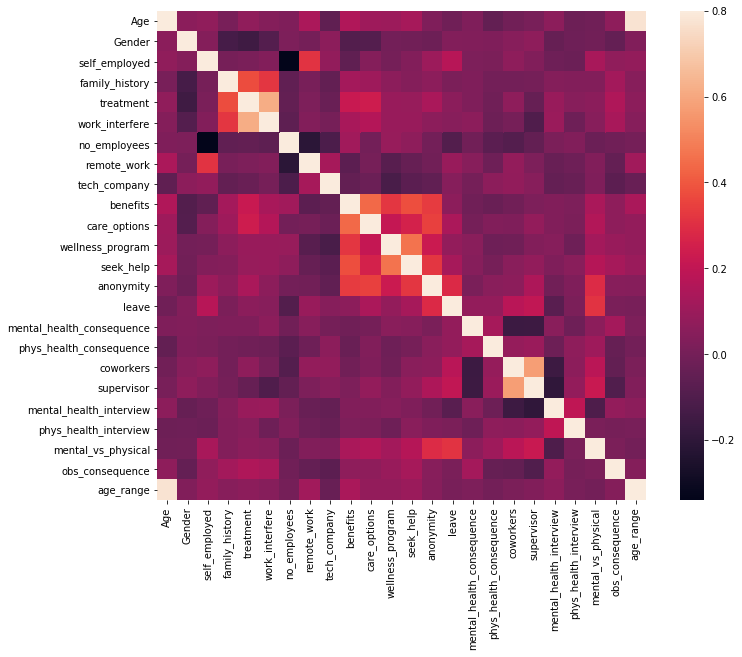

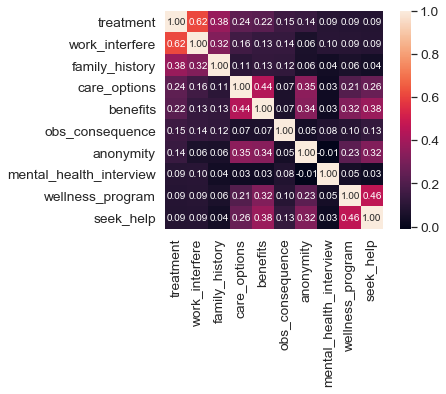

In [15]:
# macierz korelacji
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

# macierz korelacji dla kolumny "treatment"
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Na powyższej macierzy korelacji zauważyć można mocną korelację między zmiennymi work_interfere oraz treatment. Druga macierz wskazuje największe korelacje z innymi zmiennymi dla danej "treatment". Widać tutaj dużą korelację między "treatment"(czy poszukiwałeś pomocy w leczeniu choroby psychicznej?) a "work_interfere" (jeśli cierpisz na schorzenie psychiczne, czy uważasz, że przeszkadza ci ono w pracy?). 

## 5. Wykresy i wizualizacje danych

Dystrybucja i gęstość według wieku

Text(0.5, 0, 'Wiek')

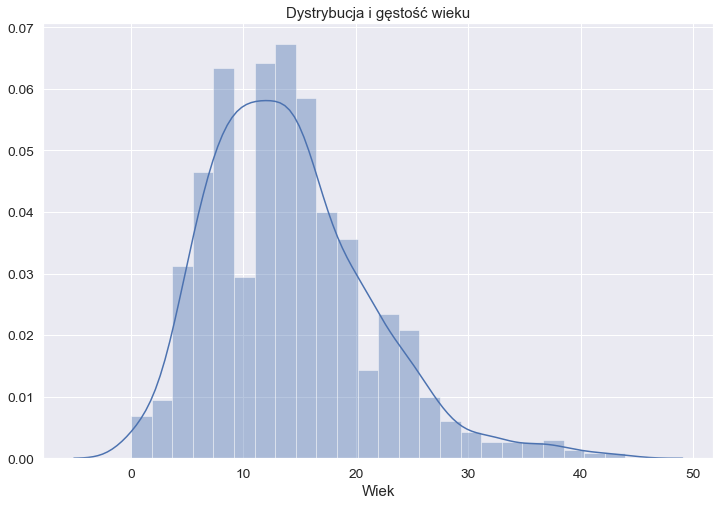

In [16]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Dystrybucja i gęstość wieku")
plt.xlabel("Wiek")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


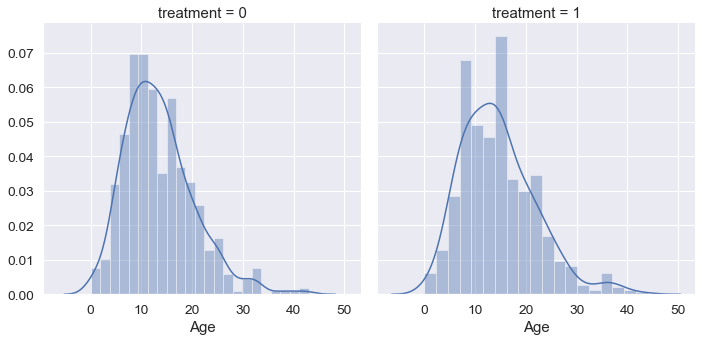

In [17]:
# podział ze względu na leczenie psychiatryczne

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

Ile osób było już poddanych leczeniu z powodu chorób psychicznych?

Text(0.5, 1.0, 'Rozkład osób ze względu na odbyte leczenie')

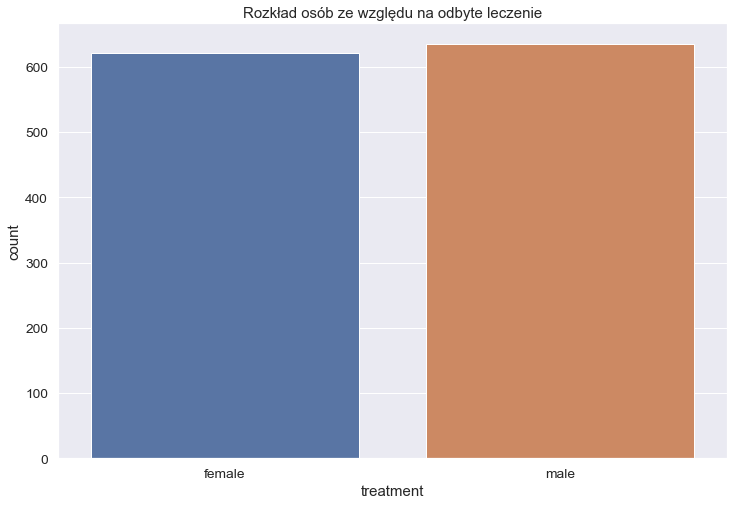

In [18]:
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Rozkład osób ze względu na odbyte leczenie')

Zagnieżdżony wykres słupkowy, aby pokazać prawdopodobieństwo stanu psychicznego w podziale na płeć

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


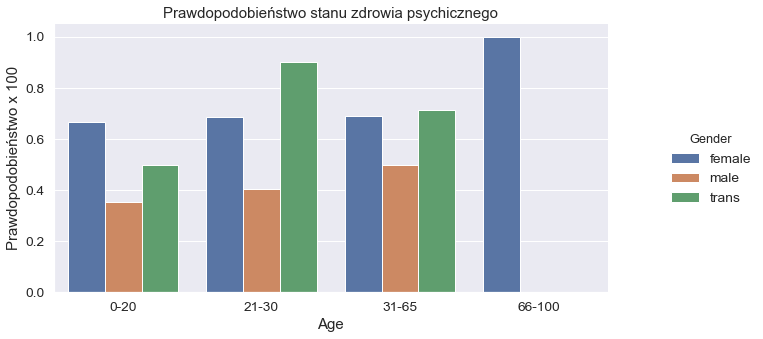

In [19]:
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Prawdopodobieństwo stanu zdrowia psychicznego')
plt.ylabel('Prawdopodobieństwo x 100')
plt.xlabel('Age')


new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Wykres słupokowy pokazujący prawdopodobieństwo chorób psyhicznych w odniesieniu do chorób psychicznych w historii rodziny

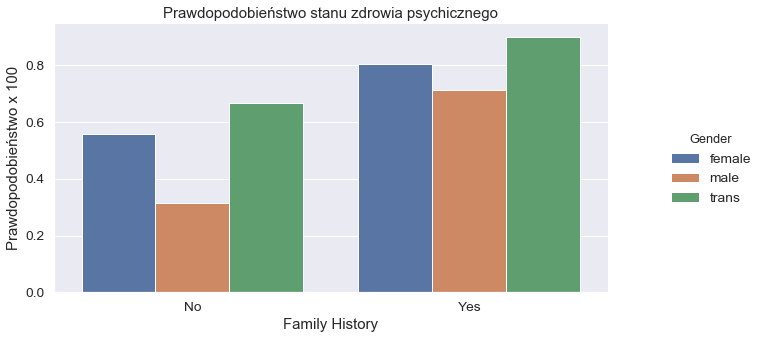

In [20]:
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Prawdopodobieństwo stanu zdrowia psychicznego')
plt.ylabel('Prawdopodobieństwo x 100')
plt.xlabel('Family History')


new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Wykres słupokowy pokazujący prawdopodobieństwo chorób psyhicznych w odniesieniu do opcji opieki psychiatrycznej, którą zapewnia pracodawca

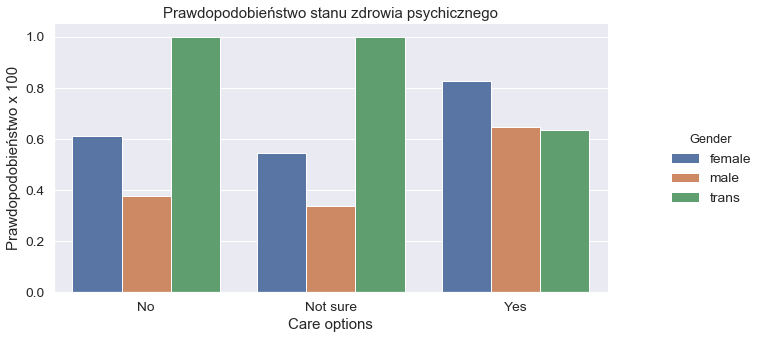

In [21]:
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Prawdopodobieństwo stanu zdrowia psychicznego')
plt.ylabel('Prawdopodobieństwo x 100')
plt.xlabel('Care options')


new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)


g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Wykres słupokowy pokazujący prawdopodobieństwo chorób psyhicznych w odniesieniu do benefitów w miejscu pracy

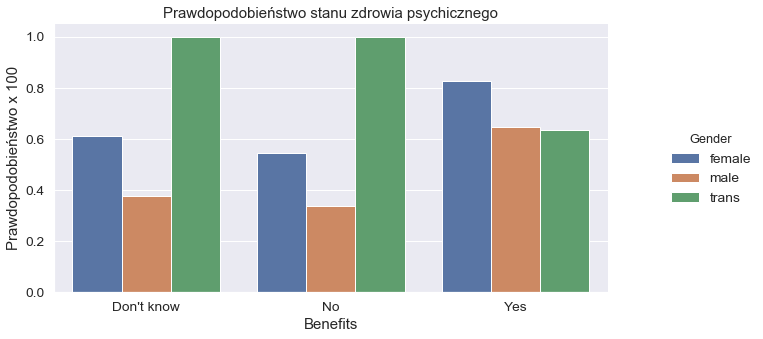

In [22]:
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Prawdopodobieństwo stanu zdrowia psychicznego')
plt.ylabel('Prawdopodobieństwo x 100')
plt.xlabel('Benefits')


new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)


g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Wykres słupokowy pokazujący prawdopodobieństwo chorób psyhicznych w odniesieniu do tego, czy stan zdrowia utrudnia pracę

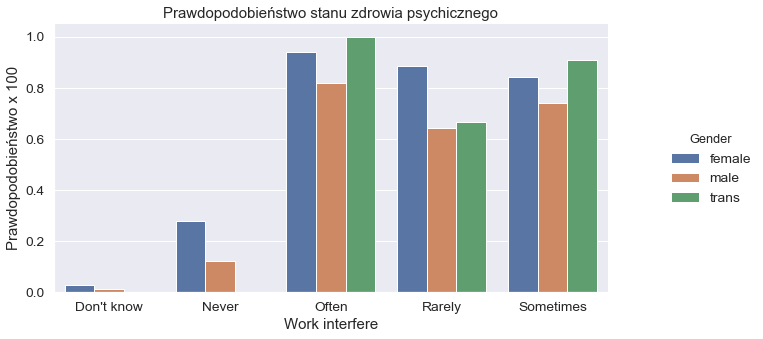

In [23]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Prawdopodobieństwo stanu zdrowia psychicznego')
plt.ylabel('Prawdopodobieństwo x 100')
plt.xlabel('Work interfere')


new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)


g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

## 6. Skalowanie i dopasowywanie 

Skalowaniu zostanie poddana wartość "Wiek", ponieważ najmocniej różni się od pozostałych danych.

Estymator MinMaxScaler() przekształca cechy, skalując każdą do określonego zakresu, tak, aby znajdowała się w podanym zakresie na zbiorze uczącym, np. od 0 do 1.

In [24]:
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,...,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,...,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,...,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,...,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,...,0,1,1,1,2,2,2,0,0,2


Dzielenie zbioru danych:

In [25]:
# definiowanie X i y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# podział X i y na zbiory testowe i uczące
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# słowniki dla końcowego wykresu 
# metoda: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()


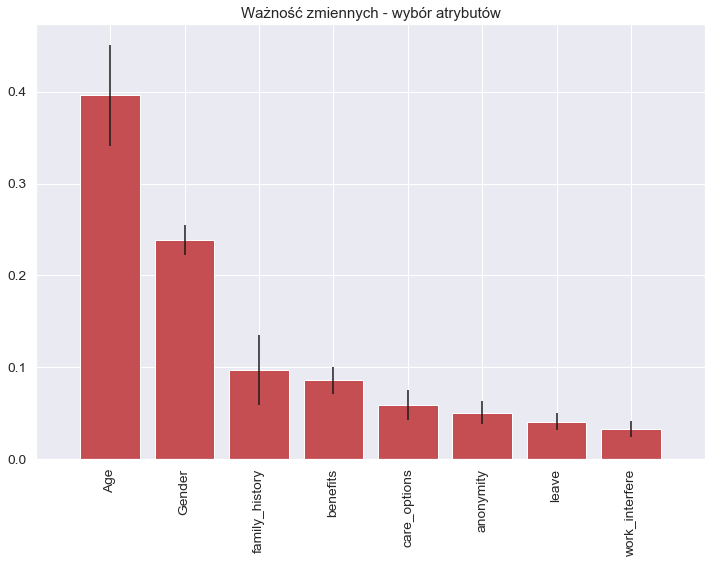

In [26]:
# budowanie drzewa decyzyjnego i obliczenie ważności dla cech
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# wykres
plt.figure(figsize=(12,8))
plt.title("Ważność zmiennych - wybór atrybutów")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

Na podstawie powyższego można stwierdzić, że dwa atrybuty, które mają największe znaczenie w zbiorze danych to wiek oraz płeć. Ważna jest także zmienna opisująca to, czy w historii rodziny występowały już schorzenia psychiczne.

## 7. Strojenie modelów klasyfikacji 

### Ocena modelów klasyfikacji 

Poniżej zostaną przedstawione funkcje, które obliczą:
* **Dokładność klasyfikacji**: procent poprawnych prognoz
* **Dokładność zerowa**: dokładność, którą można osiągnąć, zawsze przewidując najczęstszą klasę
* **Macierz pomyłek**: tabela, która opisuje wydajność/ efektywnośc modelu.
    
        1) TRUE POSITIVE (TP): przewidywanie pozytywne, faktycznie zaobserwowana klasa pozytywna (np. pozytywny wynik testu ciążowego i ciąża potwierdzona)

        2) TRUE NEGATIVE (TN): przewidywanie negatywne, faktycznie zaobserwowana klasa negatywna (np. negatywny wynik testu ciążowego i brak ciąży)

        3) FALSE POSITIVE (FN): przewidywanie pozytywne, faktycznie zaobserwowana klasa negatywna (np. pozytywny wynik testu ciążowego, jednak faktyczny brak ciąży)

        4) FALSE NEGATIVE (FN): przewidywanie negatywne, faktycznie zaobserwowana klasa pozytywna (np. negatywny wynik testu ciążowego, jednak ciąża potwierdzona)


* **ROC**: krzywa, która pokazuje zależność TP w stosunku do FP. Te dwa współczynniki wyznaczane są na podstawie macierzy konfuzji i typowo każdy pojedynczy klasyfikator można przedstawić jako punkt w przestrzeni.
* **AUC**: Area Under Curve jest współczynnikiem określającym powierzchnię pod krzywą ROC. Im większa powierzchnia tym lepszy klasyfikator. Idealny klasyfikator posiada powierzchnię rzędu 1.
                0,9-1 = doskonały
                0,8-0,9 = dobry
                0,7-0,8 = średni
                0,6-0,7 = słaby
                0,5-0,6 = nieakceptowalny 

* **Dodatkowe miary**:
            Wrażliwość / czułość (ang. sensitivity) = TP / (TP+FN)
            Specyficzność (ang. specificity) = TN / (FP+TN)

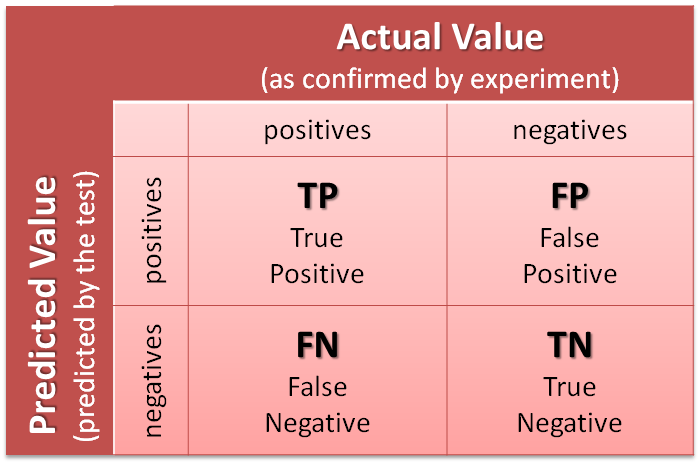

In [27]:
from PIL import Image
from IPython.display import Image
Image(filename='ConfusionMatrix.png') 

In [28]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    # Dokładność klasyfikacji: procent dobrych przewidywań
    
    # obliczenie dokładności:
    print('Dokładność:', metrics.accuracy_score(y_test, y_pred_class))
    
    # dokładność zerowa, która może być osiągana zawsze przewidując najczęstszą klasę
    
    # badanie rozkładu klas zbioru testowego
    print('Dokładność zerowa:\n', y_test.value_counts())
    
    # procent 1 - klasa
    print('Procent klasy 1:', y_test.mean())
    
    # procent 0 - klasa
    print('Procent klasy 0:',1 - y_test.mean())
    
    # porównanie prawdziwych i przewidywanych wartości odpowiedzi
    print('Prawdziwe:', y_test.values[0:25])
    print('Przewidywane:', y_pred_class[0:25])
    
    # Wnioski:
    # dokładność klasyfikacji to najłatwiejsza do zrozumienia metryka klasyfikacji
    # ale nie określa jaki jest podstawowy rozkład wartości odpowiedzi
    # i nie mówi, jakie „typy” błędów popełnia klasyfikator
    
    # Macierz Pomyłek
    # zapisuje macierz pomyłek i dzieli ją na 4 części TP, TN, FP, FN
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[wiersz, kolumna]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # wizualizacja macierzy pomyłek
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Macierz Pomyłek')
    plt.xlabel('Przewidywane')
    plt.ylabel('Prawdziwe')
    plt.show()
    
    # miary obliczane z macierzy pomyłek
    # dokładność klasyfikacji: Ogólnie, jak często klasyfikator jest poprawny?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Dokładność Klasyfikacji:', accuracy)
    
    # błąd klasyfikacji: ogólnie, jak często klasyfikator jest nieprawidłowy?
    print('Błąd klasyfikacji:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    # False Positive: Jeśli rzeczywista wartość jest negatywna, to jak często prognoza jest błędna?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive:', false_positive_rate)
    
    # Precyzja: kiedy prognozowana jest wartość pozytywna, jak często prognoza jest poprawna?
    print('Precyzja:', metrics.precision_score(y_test, y_pred_class))
    
    
    # Poniżej: pierwszy argument to prawdziwe wartości, drugi argument to przewidywane prawdopodobieństwa
    print('AUC:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # walidacja krzyżowa AUC
    print('Walidacja krzyżowa AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    # dostosowywanie progu klasyfikacji
    ##########################################
    # wydrukuj pierwszych 10 przewidywanych odpowiedzi
    # tablica 1 wymiarowa (wektor) wartości binarnych (0, 1)
    print('10 pierwszych przewidywanych odpowiedzi:\n', model.predict(X_test)[0:10])

    # wypisuje pierwszych 10 przewidywanych prawdopodobieństw przynależności do klasy
    print('10 pierwszych przewidywanych prawdopodobieństw członków klasy:\n', model.predict_proba(X_test)[0:10])

    # wypisuje pierwszych 10 przewidywanych prawdopodobieństw dla klasy 1
    model.predict_proba(X_test)[0:10, 1]
    
    # przechowuje przewidywane prawdopodobieństwa dla klasy 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram przewidywanych prawdopodobieństw
        # dopasowanie rozmiaru czcionki
        plt.rcParams['font.size'] = 12
        
        plt.hist(y_pred_prob, bins=8)
        
        # oś x - od 0 do 1
        plt.xlim(0,1)
        plt.title('Histogram przewidywanych prawdopodobieństw')
        plt.xlabel('Przewidywane prawdopodobieństwo leczenia')
        plt.ylabel('Częstość')
    
    
    # przewidywanie leczenia, jeśli przewidywane prawdopodobieństwo jest większe niż 0,3
    # zwróci 1 dla wszystkich wartości powyżej 0,3 i 0, w przeciwnym razie 
    # wyniki są w 2 wymiarach, więc wycinamy pierwszą kolumnę
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # wypisuje pierwsze 10 przewidywanych prawdopodobieństw
    print('10 pierwszych przewidywanych prawdopodobieństw:\n', y_pred_prob[0:10])
    
    ##########################################
    # Krzywa ROC Curves i pole Area Under the Curve (AUC)
    ##########################################
    
    # Pytanie: jak różne progi wpływają na czułość(sensitivity) i swoistość(specificity), bez faktycznej zmiany progu?
    # Rozwiązanie: krzywa ROC  
        
    # AUC to procent wykresu ROC, który znajduje się pod krzywą
    # Wyższa wartość = lepszy klasyfikator
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # WAŻNE: pierwszy argument to prawdziwe wartości, drugi argument to przewidywane prawdopodobieństwa
    # przekazujemy atrybuty: y_test i y_pred_prob
    # nie używamy y_pred_class, ponieważ da to nieprawidłowe wyniki bez generowania błędu
    # roc_curve zwraca 3 obiekty FP RATE, TRU POSTIVIE RATE, progi
    # FPR: współczynnik fałszywie pozytywnych wyników
    # TPR: współczynnik prawdziwie pozytywnych wyników

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('krzywa ROC dla klasyfikatora leczenia')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # funkcja, która pobiera progi jako atrybut i wypisuje czułość (sensitivity) i specyficzność (specificity)
    def evaluate_threshold(threshold):
        #Sensitivity: Kiedy rzeczywista wartość jest pozytywna, jak często prognoza jest poprawna?
        #Specificity: Jeśli rzeczywista wartość jest negatywna, jak często prognoza jest poprawna?
        print('Sensitivity dla ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity dla ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # Spsoób na ustawianie progów
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
        
    
    return accuracy

### Doskonalenie modelu walidacją krzyżową

Funkcja „cross_val_score” dzieli dane przykładowo 5 razy. Następnie dla każdego podziału dopasowuje dane do 4 fałd i ocenia piątą. Następnie podaje 5 wyników, na podstawie których można obliczyć średnią i wariancję wyniku. Wykorzystuje się ją na przykład po to, aby dostroić parametry i uzyskać szacunkowy wynik.

Model jest trenowany przy użyciu K-1 "fałd" jako danych uczących.
Wynikowy model jest weryfikowany na podstawie pozostałych danych. Proces jest powtarzany K razy, a miara wydajności, taka jak „Dokładność”, jest obliczana na każdym etapie.

In [29]:
def tuningCV(knn):
    
    # szukanie optymalnej wartości K dla algorytmu KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # wykreśl wartość K dla KNN (oś x) VS. sprawdzona krzyżowo dokładność (oś y)
    plt.plot(k_range, k_scores)
    plt.xlabel('Wartość K dla KNN')
    plt.ylabel('Dokładność walidacją krzyżową')
    plt.show()

### Doskonalenie z GridSearchCV

GridSearchCV to proces wykonywania strojenia hiperparametrów w celu określenia optymalnych wartości dla danego modelu. Wydajność modelu w znacznym stopniu zależy od wartości hiperparametrów. Należy pamiętać, że nie ma możliwości wcześniejszego poznania najlepszych wartości hiperparametrów, więc w idealnym przypadku musimy wypróbować wszystkie możliwe wartości, aby poznać optymalne wartości. Wykonanie tego ręcznie może zająć sporą ilość czasu i zasobów, dlatego używamy GridSearchCV do automatyzacji dostrajania hiperparametrów.

GridSearchCV to funkcja znajdująca się w pakiecie model_selection Scikit-learn. Funkcja ta pomaga przechodzić przez predefiniowane hiperparametry i dopasować estymator (model) do zestawu treningowego. Na koniec można więc wybrać najlepsze parametry z wymienionych hiperparametrów.

In [30]:
def tuningGridSerach(knn):
    # wydajniejsze strojenie parametrów za pomocą GridSearchCV
    # definiowanie wartości parametrów, które mają być przeszukiwane
    k_range = list(range(1, 31))
    print(k_range)
    
    # utwórz siatkę parametrów: odwzoruj nazwy parametrów na wartości, które mają być przeszukiwane
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    # siatka:
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # dopasuj siatkę do danych
    grid.fit(X, y)
    
    # wyświetl pełne wyniki (lista nazwanych krotek)
    grid.cv_results_
    
    # zbadaj pierwszą krotkę
    print(grid.cv_results_[0].parameters)
    print(grid.cv_results_[0].cv_validation_scores)
    print(grid.cv_results_[0].mean_validation_score)
    
    # utwórz listę tylko średnich wyników
    grid_mean_scores = [result.mean_validation_score for result in grid.cv_results_]
    print(grid_mean_scores)
    
    # wykres wyników
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    # zbadaj najlepszy model
    print('GridSearch Najlepszy Wynik ', grid.best_score_)
    print('GridSearch Najlepsze Paramtery ', grid.best_params_)
    print('GridSearch Najlepszy Estymator ', grid.best_estimator_)


### Doskonalenie modelu z RandomizedSearchCV

W scikit-learn dostępne są dwa ogólne podejścia do wyszukiwania parametrów: dla podanych wartości GridSearchCV wyczerpująco uwzględnia wszystkie kombinacje parametrów, podczas gdy RandomizedSearchCV może próbkować określoną liczbę kandydatów z przestrzeni parametrów o określonym rozkładzie.
Parametry estymatora użyte do zastosowania tych metod są optymalizowane przez przeszukiwanie krzyżowo sprawdzanie ustawień parametrów.

In [31]:
def tuningRandomizedSearchCV(model, param_dist):
    # wyszukiwanie wielu parametrów jednocześnie
    # n_iter kontroluje ilość wyszukiwań
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.cv_results_
    
    # zbadaj najlepszy model
    print('Rand. Najlepszy Wynik: ', rand.best_score_)
    print('Rand. Najlepsze Parametry: ', rand.best_params_)
    
    # uruchom RandomizedSearchCV 20 razy (z n_iter = 10) i zapisz najlepszy wynik
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

### Doskonalenie modelu z przeszukiwaniem wielu parametrów jednocześnie

In [32]:
def tuningMultParam(knn):    
    # wyszukiwanie wielu parametrów jednocześnie
    # definiowanie wartości parametrów, które mają być przeszukiwane
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
        
    # utwórz siatkę parametrów: odwzoruj nazwy parametrów na wartości, które mają być przeszukiwane
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    
    # dopasuj siatkę do danych
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    
    # zobacz pełne wyniki
    print(grid.cv_results_)
    
    # zbadaj najlepszy model
    print('Multiparam. Najlepszy Wynik: ', grid.best_score_)
    print('Multiparam. Najlepsze Parametry: ', grid.best_params_)

## 8. Ocena modeli klasyfikacji

### Regresja Logistyczna

W naukach biologiczno-medycznych często mamy do czynienia ze zmiennymi typu dychotomicznego, czyli np. zmienną  Występowanie_Nowotworu (1-tak, 0-nie) czy zmienna Przeżycie (1-tak, 0-nie). Podobna sytuacja występuje w opsiywanym zbiorze danym, gdzie 1=wymagane leczenie psychologiczne a 0=brak konieczności leczenia.

W takich zagadnieniach ważne jest, jakie zmienne istotnie wpływają na przeżycie,
wystąpienie nowotworu lub konieczność leczenia. W tego typu sytuacjach świetnie sprawdza się właśnie regresja logistyczna.
Regresja logistyczna jest bardzo podobna do metod klasycznej regresji. Najważniejszą różnicą są bardziej skomplikowane i czasochłonne obliczenia. Ogólnie rzecz ujmując, regresja logistyczna jest modelem matematycznym, pozwalającym opisać
wpływ kilku zmiennych $X_1$, $X_2$, ..., $X_k$ na dychotomiczną zmienną $Y$.

In [33]:
def logisticRegression():
    # trenowanie modelu regresji logistycznej na zbiorze uczącym
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # prognozy klasowe dla zestawu testowego
    y_pred_class = logreg.predict(X_test)
    
    print('########### Regresja Logistyczna ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    # Dane do końcowego wykresu
    methodDict['Log. Regres.'] = accuracy_score * 100

########### Regresja Logistyczna ###############
Dokładność: 0.7962962962962963
Dokładność zerowa:
 0    191
1    187
Name: treatment, dtype: int64
Procent klasy 1: 0.4947089947089947
Procent klasy 0: 0.5052910052910053
Prawdziwe: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Przewidywane: [1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


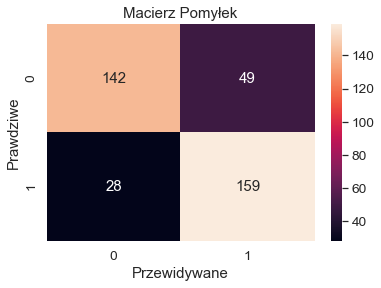

Dokładność Klasyfikacji: 0.7962962962962963
Błąd klasyfikacji: 0.20370370370370372
False Positive: 0.25654450261780104
Precyzja: 0.7644230769230769
AUC: 0.7968614385306716
Walidacja krzyżowa AUC: 0.8753623882722146
10 pierwszych przewidywanych odpowiedzi:
 [1 0 0 0 1 1 0 1 0 1]
10 pierwszych przewidywanych prawdopodobieństw członków klasy:
 [[0.09193053 0.90806947]
 [0.95991564 0.04008436]
 [0.96547467 0.03452533]
 [0.78757121 0.21242879]
 [0.38959922 0.61040078]
 [0.05264207 0.94735793]
 [0.75035574 0.24964426]
 [0.19065116 0.80934884]
 [0.61612081 0.38387919]
 [0.47699963 0.52300037]]
10 pierwszych przewidywanych prawdopodobieństw:
 [[0.90806947]
 [0.04008436]
 [0.03452533]
 [0.21242879]
 [0.61040078]
 [0.94735793]
 [0.24964426]
 [0.80934884]
 [0.38387919]
 [0.52300037]]


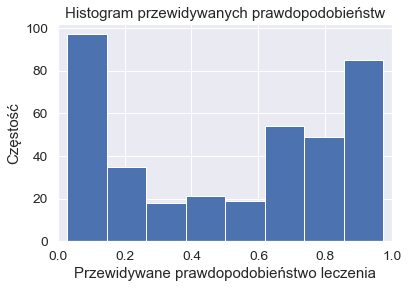

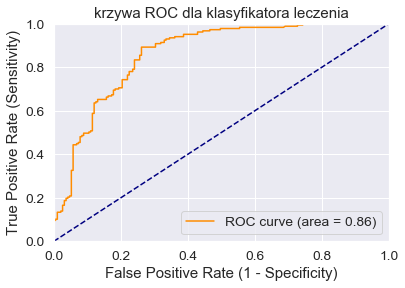

[[142  49]
 [ 28 159]]


In [34]:
logisticRegression()

### Klasyfikator KNN

Metoda K Najbliższych Sąsiadów (k-Nearest Neighbors KNN) należy do grupy algorytmów leniwych (lazy algorithms), czyli takich, które nie tworzą wewnętrznej reprezentacji danych uczących, lecz szukają rozwiązania dopiero w momencie pojawienia się wzorca testującego, np. właśnie klasyfikacji.

Metoda k Najbliższych Sąsiadów (k-Nearest Neighbors) wyznacza k "sąsiadów", do których badany element ma najbliżej dla wybranej metryki (np. Euklidesowej), a następnie wyznacza wynik w oparciu o "głos większości".

W przypadku dużej ilości wzorców lub dużego wymiaru danych klasyfikacja wymaga zwykle porównania z każdym wzorcem, co wiąże się z ogromnym narzutem czasowym w trakcie klasyfikacji. 



In [35]:
def Knn():
    # obliczenie najlepszych parametrów
    knn = KNeighborsClassifier(n_neighbors=5)
    
    #Parametry można również obliczyć wykorzytsując następujące metody:
    #tuningCV(knn)
    #tuningGridSerach(knn)
    #tuningMultParam(knn)
    
    # zdefiniować wartości parametrów, które mają być przeszukiwane
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    
    # określ „rozkłady parametrów” zamiast „siatki parametrów”
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)
    
    # wytrenuj model KNeighborsClassifier na zbiorze uczącym
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)
    
    # prognozy klasowe dla zestawu testowego
    y_pred_class = knn.predict(X_test)
    
    print('########### Klasyfikator KNN ###############')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

    # dane do końcowego wykresu
    methodDict['KNN'] = accuracy_score * 100

Rand. Najlepszy Wynik:  0.8209714285714286
Rand. Najlepsze Parametry:  {'weights': 'uniform', 'n_neighbors': 27}
[0.815, 0.823, 0.823, 0.812, 0.818, 0.812, 0.815, 0.823, 0.82, 0.823, 0.823, 0.815, 0.821, 0.815, 0.819, 0.821, 0.815, 0.815, 0.811, 0.82]
########### Klasyfikator KNN ###############
Dokładność: 0.8042328042328042
Dokładność zerowa:
 0    191
1    187
Name: treatment, dtype: int64
Procent klasy 1: 0.4947089947089947
Procent klasy 0: 0.5052910052910053
Prawdziwe: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Przewidywane: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


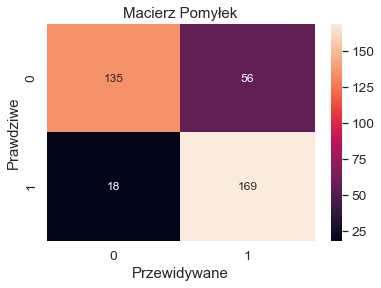

Dokładność Klasyfikacji: 0.8042328042328042
Błąd klasyfikacji: 0.1957671957671958
False Positive: 0.2931937172774869
Precyzja: 0.7511111111111111
AUC: 0.8052747991152673
Walidacja krzyżowa AUC: 0.8782819116296456
10 pierwszych przewidywanych odpowiedzi:
 [1 0 0 0 1 1 0 1 1 1]
10 pierwszych przewidywanych prawdopodobieństw członków klasy:
 [[0.33333333 0.66666667]
 [1.         0.        ]
 [1.         0.        ]
 [0.66666667 0.33333333]
 [0.37037037 0.62962963]
 [0.03703704 0.96296296]
 [0.59259259 0.40740741]
 [0.37037037 0.62962963]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]]
10 pierwszych przewidywanych prawdopodobieństw:
 [[0.66666667]
 [0.        ]
 [0.        ]
 [0.33333333]
 [0.62962963]
 [0.96296296]
 [0.40740741]
 [0.62962963]
 [0.66666667]
 [0.66666667]]


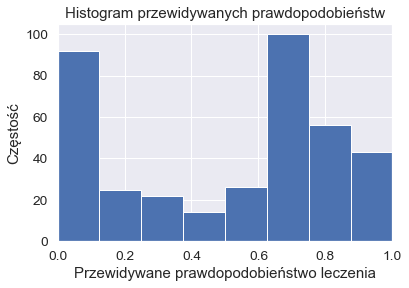

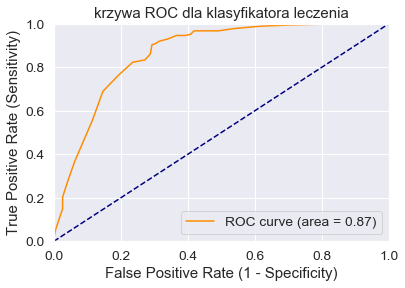

[[135  56]
 [ 18 169]]


In [36]:
Knn()

### Klasyfikator Drzewa Decyzyjnego

Drzewo decyzyjne jest grafem o strukturze drzewiastej,
gdzie każdy wierzchołek wewnętrzny reprezentuje test na atrybucie (atrybutach), każdy łuk reprezentuje wynik testu, a każdy liść reprezentuje pojedynczą klasę lub rozkład wartości klas.

1) Drzewo zaczyna od pojedynczego węzła reprezentującego cały zbiór treningowy. <br>
2) Jeżeli wszystkie przykłady należą do jednej klasy decyzyjnej, to zbadany węzeł staje się liściem i jest on etykietowany tą decyzją. <br>
3) W przeciwnym przypadku algorytm wykorzystuje miarę entropii (funkcja przyrostu informacji) jako heurystyki do wyboru atrybutu, który najlepiej dzieli zbiór przykładów treningowych. <br>
4) Dla każdego wyniku testu tworzy się jedno odgałęzienie i przykłady treningowe są odpowiednio rozdzielone do nowych węzłów (poddrzew). <br>
5) Algorytm działa dalej w rekurencyjny sposób dla zbiorów przykładów przydzielonych do poddrzew. <br>
6) Algorytm kończy się, gdy kryterium stopu jest spełnione.

In [37]:
def treeClassifier():
    # obliczenie najlepszych parametrów
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    
    # trenowanie model drzewa decyzyjnego na zbiorze uczącym
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)
    
    # prognozy klasowe dla zestawu testowego
    y_pred_class = tree.predict(X_test)
    
    print('########### Drzewo Decyzyjne ###############')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    # dane do końcowego wykresu
    methodDict['Tree clas.'] = accuracy_score * 100

Rand. Najlepszy Wynik:  0.8305206349206349
Rand. Najlepsze Parametry:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 4}
[0.831, 0.83, 0.831, 0.811, 0.823, 0.831, 0.831, 0.829, 0.819, 0.831, 0.83, 0.831, 0.831, 0.83, 0.829, 0.831, 0.829, 0.823, 0.831, 0.831]
########### Drzewo Decyzyjne ###############
Dokładność: 0.8068783068783069
Dokładność zerowa:
 0    191
1    187
Name: treatment, dtype: int64
Procent klasy 1: 0.4947089947089947
Procent klasy 0: 0.5052910052910053
Prawdziwe: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Przewidywane: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


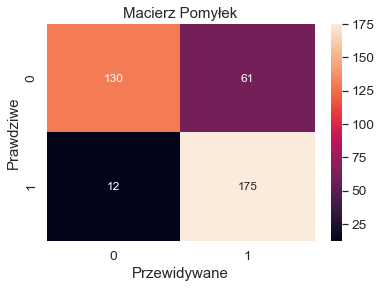

Dokładność Klasyfikacji: 0.8068783068783069
Błąd klasyfikacji: 0.19312169312169314
False Positive: 0.3193717277486911
Precyzja: 0.7415254237288136
AUC: 0.8082285746283282
Walidacja krzyżowa AUC: 0.8794306073683954
10 pierwszych przewidywanych odpowiedzi:
 [1 0 0 0 1 1 0 1 1 1]
10 pierwszych przewidywanych prawdopodobieństw członków klasy:
 [[0.18823529 0.81176471]
 [0.99375    0.00625   ]
 [0.99375    0.00625   ]
 [0.88135593 0.11864407]
 [0.36097561 0.63902439]
 [0.05172414 0.94827586]
 [0.88135593 0.11864407]
 [0.11320755 0.88679245]
 [0.36097561 0.63902439]
 [0.36097561 0.63902439]]
10 pierwszych przewidywanych prawdopodobieństw:
 [[0.81176471]
 [0.00625   ]
 [0.00625   ]
 [0.11864407]
 [0.63902439]
 [0.94827586]
 [0.11864407]
 [0.88679245]
 [0.63902439]
 [0.63902439]]


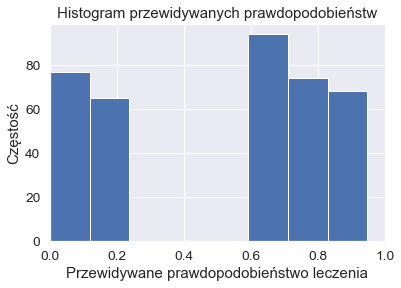

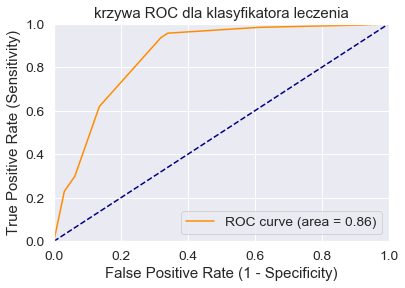

[[130  61]
 [ 12 175]]


In [38]:
treeClassifier()

### Random Forest

Random Forest to potężna, ale stosunkowo prosta technika eksploracji danych i nadzorowanego uczenia maszynowego. Pozwala na szybką i automatyczną identyfikację istotnych informacji z bardzo dużych zbiorów danych. Największą zaletą algorytmu jest to, że polega on na zbieraniu wielu prognoz (drzew), a nie zaufaniu pojedynczemu. Dzięki Random Forest możliwa jest jednocześnie:
- Klasyfikacja klasyczną (dane wejściowe = dane kategorialne), gdzie każde drzewo "oddaje głos" na ostateczną prognozę.
- Regresja (dane wejściowe = dane ciągłe), dzięki czemu wyniki drzewa są uśredniane, aby utworzyć ostateczną prognozę.

Używając Random Forest umacnia się klasyfikację/ regresję, gromadząc prognozy różnych drzew.

In [39]:
def randomForest():
    # obliczenie najlepszych parametrów
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)
    
    # budowa i dopasowanie my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)
    
    # prognozy klasowe dla zestawu testowego
    y_pred_class = my_forest.predict(X_test)
    
    print('########### Random Forest ###############')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    # dane do wykresu
    methodDict['R. Forest'] = accuracy_score * 100

Rand. Najlepszy Wynik:  0.8313206349206348
Rand. Najlepsze Parametry:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 4}
[0.831, 0.831, 0.831, 0.836, 0.831, 0.834, 0.831, 0.831, 0.832, 0.832, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.834]
########### Random Forest ###############
Dokładność: 0.8121693121693122
Dokładność zerowa:
 0    191
1    187
Name: treatment, dtype: int64
Procent klasy 1: 0.4947089947089947
Procent klasy 0: 0.5052910052910053
Prawdziwe: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Przewidywane: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


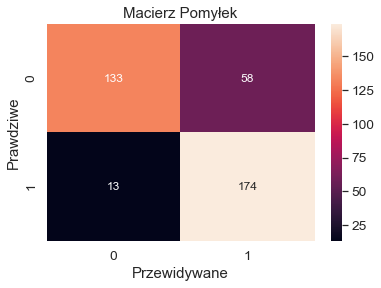

Dokładność Klasyfikacji: 0.8121693121693122
Błąd klasyfikacji: 0.1878306878306878
False Positive: 0.3036649214659686
Precyzja: 0.75
AUC: 0.8134081809782457
Walidacja krzyżowa AUC: 0.8934280651104528
10 pierwszych przewidywanych odpowiedzi:
 [1 0 0 0 1 1 0 1 1 1]
10 pierwszych przewidywanych prawdopodobieństw członków klasy:
 [[0.2555794  0.7444206 ]
 [0.95069083 0.04930917]
 [0.93851009 0.06148991]
 [0.87096597 0.12903403]
 [0.40653554 0.59346446]
 [0.17282958 0.82717042]
 [0.89450448 0.10549552]
 [0.4065912  0.5934088 ]
 [0.20540631 0.79459369]
 [0.19337644 0.80662356]]
10 pierwszych przewidywanych prawdopodobieństw:
 [[0.7444206 ]
 [0.04930917]
 [0.06148991]
 [0.12903403]
 [0.59346446]
 [0.82717042]
 [0.10549552]
 [0.5934088 ]
 [0.79459369]
 [0.80662356]]


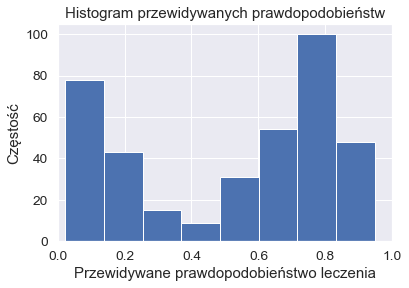

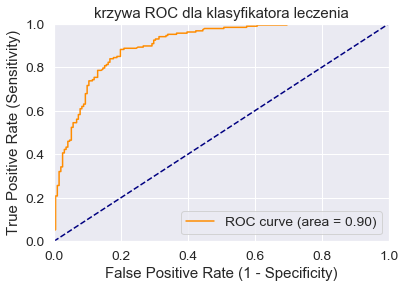

[[133  58]
 [ 13 174]]


In [40]:
randomForest()

## Boosting

Boosting jest ogólną metodą służącą zwiększeniu skuteczności dowolnego algorytmu uczenia. Ideą jest zbudowanie "mocnego i złożonego klasyfikatora" ze "słabych i prostych klasyfikatorów". Słabym klasyfikatorem nazywamy klasyfikator stosunkowo prosty, o niezbyt dużej sile wyra»ania, potrafiący klasyfikować dane testowe ze skutecznością większą niż 50%.

Nazwa wzięła się od Adaptative Boosting (z ang. wzmocnienie adaptacyjne).
AdaBoost w kolejnych $t$ iteracjach trenuje $t$ "słabych" klasyfikatorów na zbiorze przykładów $D$ ze zmienianymi wagami - metoda pozwalająca zbudować "dobry" zespół z "mniej" zdolnych członków.


In [41]:
def boosting():
    # budowanie i dopasowywanie
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)
    
    print('########### Boosting ###############')
    
    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

########### Boosting ###############
Dokładność: 0.8174603174603174
Dokładność zerowa:
 0    191
1    187
Name: treatment, dtype: int64
Procent klasy 1: 0.4947089947089947
Procent klasy 0: 0.5052910052910053
Prawdziwe: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Przewidywane: [1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


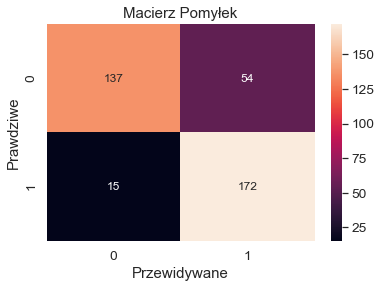

Dokładność Klasyfikacji: 0.8174603174603174
Błąd klasyfikacji: 0.18253968253968256
False Positive: 0.28272251308900526
Precyzja: 0.7610619469026548
AUC: 0.8185317915838397
Walidacja krzyżowa AUC: 0.8746279095195426
10 pierwszych przewidywanych odpowiedzi:
 [1 0 0 0 0 1 0 1 1 1]
10 pierwszych przewidywanych prawdopodobieństw członków klasy:
 [[0.49924555 0.50075445]
 [0.50285507 0.49714493]
 [0.50291786 0.49708214]
 [0.50127788 0.49872212]
 [0.50013552 0.49986448]
 [0.49796157 0.50203843]
 [0.50046371 0.49953629]
 [0.49939483 0.50060517]
 [0.49921757 0.50078243]
 [0.49897133 0.50102867]]
10 pierwszych przewidywanych prawdopodobieństw:
 [[0.50075445]
 [0.49714493]
 [0.49708214]
 [0.49872212]
 [0.49986448]
 [0.50203843]
 [0.49953629]
 [0.50060517]
 [0.50078243]
 [0.50102867]]


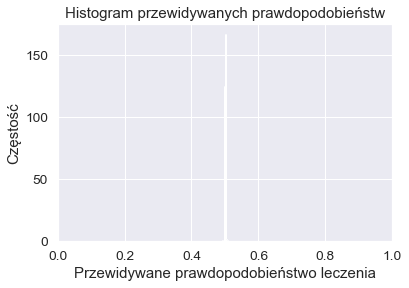

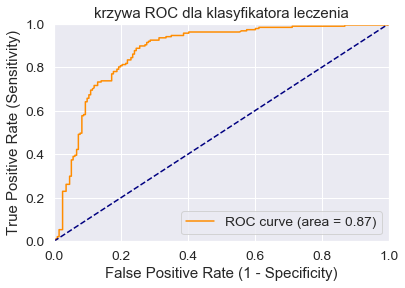

[[137  54]
 [ 15 172]]


In [42]:
boosting()

Dokładność algorytmu Boosting wyniosła 81,75%.
49% próbek sklasyfikowano do klasy 1, czyli jako osoby, które wymagają leczenia, a 51% do klasy 0, czyli jako niewymagających leczenia z powodu chorób psychicznych. 
Błąd klasyfikacji wyniósł 18,25%, a precyzja 76,1%.

Z macierzy pomyłek można odczytać informację, że 15 próbek klasy "1" mylnie zakwalifikowano jako obiekty klasy "0" i 54 obiekty klasy "0" mylnie zakwalifikowano jako klasę "1".
137 obiekty klasy "0" zostały poprawnie zakwalifikowane jako klasa "0", a 172 obiekty klasy "1" jako klasa "1"

## 9. Przewidywanie z Sieciami Neuronowymi
Stworzenie funkcji wejściowych, aby dostarczyć i przygotować dane do uczenia, oceny i prognozowania.

In [43]:
import tensorflow as tf
import argparse

batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    """Funkcja wejściowa do uczenia"""
    # Przekonwertuj dane wejściowe na zestaw danych
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Potasuj, powtarzaj i grupuj przykłady
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    """Funkcja wejściowa do oceny lub przewidywania"""
    features=dict(features)
    if labels is None:
        # Bez etykiet, używaj tylko cech
        inputs = features
    else:
        inputs = (features, labels)

    # Przekonwertuj dane wejściowe na zestaw danych
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Zestaw przykładów
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Zwróć zbiór danych
    return dataset

### Zdefiniuj  kolumny cech
Kolumna cech to obiekt opisujący, w jaki sposób model powinien wykorzystywać surowe dane wejściowe ze słownika cech. Podczas tworzenia modelu estymatora przekazywana jest mu lista kolumn cech, które opisują każdą z cech, które model ma używać.

In [44]:
import tensorflow as tf
# Zdefiniuj kolumny cech z wykorzystaniem biblioteki Tensorflow
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
care_options = tf.feature_column.numeric_column("care_options")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, family_history, benefits, care_options, anonymity, leave, work_interfere]

### Utworzenie estymatora
Opisywany problem jest klasycznym problemem klasyfikacyjnym. Chcemy przewidzieć, czy pacjent musi być leczony, czy nie. Wykorzystany zostanie tf.estimator.DNNClassifier dla głębokich modeli, które wykonują klasyfikację wieloklasową.

In [45]:
# Zbuduj Głęboką Sieć Neuronową (DNN) z 2 ukrytymi warstwami i 10 węzłami w każdej ukrytej warstwie
model = tf.compat.v1.estimator.DNNClassifier(feature_columns=feature_columns,
                                    hidden_units=[10, 10],
                                       optimizer=tf.compat.v1.train.ProximalAdagradOptimizer(
                                      learning_rate=0.1,
                                      l1_regularization_strength=0.001
                                    )
                                    )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\magda\\AppData\\Local\\Temp\\tmpfsho1bf7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Uczenie, ocena i predykcja
Teraz, gdy utworozny jest już obiekt Estimator, można wywołać metody, aby wykonać następujące czynności:

* Uczyć/trenować model.
* Ocenić wytrenowany model.
* Użyj wytrenowanego modelu do tworzenia prognoz.

**1) Trenowanie modelu**

Argument 'kroki' przekazuje metodzie, aby przerwała trening po kilku krokach treningowych.

In [46]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\magda\AppData\Local\Temp\tmpfsho1bf7\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 72.50563, step = 0
INFO:tensorflow:global_step/sec: 759.081
INFO:tensorflow:loss = 42.490772, step = 100 (0.133 sec)
INFO:tensorflow:global_step/sec: 1056.65
INFO:tensorflow:loss = 33.184967, step = 200 (0.095 sec)
INFO:tensorflow:global_step/sec: 1065.54
INFO:tensorflow:loss = 39.789085, step = 300 (0.094 sec)
INFO:tensorflow:global_

**2) Ocena wytrenowanego modelu**

Teraz, gdy model został wytrenowany, można uzyskać statystyki dotyczące jego wydajności. Poniższy kod ocenia dokładność wytrenowanego modelu na danych testowych.

In [47]:
# Ocena modelu
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nZbiór testowy dokładność:: {accuracy:0.2f}\n'.format(**eval_result))

#Data for final graph
accuracy = eval_result['accuracy'] * 100
methodDict['Sieci Neuronowe DNNClasif.'] = accuracy

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-27T22:04:55Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\magda\AppData\Local\Temp\tmpfsho1bf7\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.36137s
INFO:tensorflow:Finished evaluation at 2021-01-27-22:04:56
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7830688, accuracy_baseline = 0.505291, auc = 0.8681161, auc_precision_recall = 0.8470164, average_loss = 0.48160607, global_step = 1000, label/mean = 0.49470899, loss = 45.511772, precision = 0.7375566, prediction/mean = 0.502763, recall = 0.8716577
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users

**3) Predykcja z wytrenowanego modelu**

Teraz gdy model jest już wyszkolony i daje dobre wyniki oceny, można go użyć, aby przewidzieć, czy pacjent wymaga leczenia, czy nie.

In [48]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\magda\AppData\Local\Temp\tmpfsho1bf7\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [49]:
# generowanie predyjcji z wytrenowanego modelu
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')

# Słownik dla predykcji
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id] # Probability
    
    # dodawanie do DataFrame
    col1.append(idx) # Index
    col2.append(v) # Prediction
    col3.append(input) # Expecter
    
   
    #print(template.format(idx, v, 100 * probability, input))


results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,929,0,0
1,901,1,1
2,579,1,1
3,367,1,1
4,615,1,1


## 10. Wykres powodzenia metod

In [50]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Metoda')
    plt.ylabel('Procent')
    plt.title('Dokładność metody')
     
    plt.show()

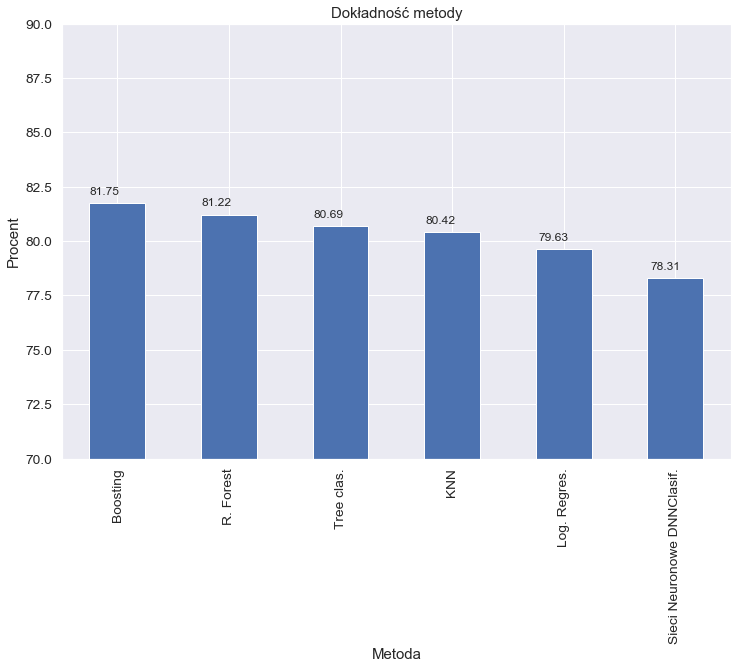

In [51]:
plotSuccess()

## 11. Predykcje na zbiorze testowym

W trakcie analizy stwierdzono, że najlepszą metodą klasyfikacji jest alogrytm **Boosting**, którego dokładność wyniosła 81,75%. Używamy zatem AdaBoostClassifier.

In [52]:
X_test.head()

,Age,Gender,family_history,benefits,care_options,anonymity,leave,work_interfere
5,0.340909,1,1,2,1,0,0,4
494,0.159091,1,0,0,1,0,0,0
52,0.295455,1,0,0,0,0,0,0
984,0.204545,1,0,2,1,2,4,1
186,0.136364,1,0,0,0,0,2,4


In [53]:
# Predykcję najlepszą metodą - Boosting
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)


In [54]:
# Zapisz wyniki predykcji do pliku csv
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
results.to_csv('results.csv', index=False)
results.head()

,Index,Treatment
0,5,1
1,494,0
2,52,0
3,984,0
4,186,0


#### Klasyfikacja na przykładowym, innym zbiorze danych:



In [55]:
dane_do_testu = pd.read_excel('dane_do_testu.xlsx')

In [56]:
dane_do_testu.head()

,Age,Gender,family_history,benefits,care_options,anonymity,leave,work_interfere
0,0.456,1,1,2,1,0,0,0
1,0.289,1,0,2,0,0,4,1
2,0.156,1,0,0,0,2,3,1
3,0.178,1,0,0,0,1,2,2
4,0.210,0,0,0,2,1,1,0


In [57]:
clf2 = AdaBoostClassifier()
clf2.fit(X, y)
dfTestPredictions2 = clf2.predict(dane_do_testu)
results2 = pd.DataFrame({'Index': dane_do_testu.index, 'Treatment': dfTestPredictions2})
results2

,Index,Treatment
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
5,5,0
6,6,1
7,7,1
8,8,1
9,9,1


Podsumowując, powyższą technikę można wykorzystywać do predyckji leczenia psychiatrycznego w przyszłości dla innych pacjentów. Korzystając z algorytmu Boosting można z powodzeniem przewidywać to, czy dana osoba wymaga leczenia. Dokładność metody jest wysoka, a błąd predykcji niski.

Inną, także dobrą metodą jest Random Forest, który w tej sytuacji radził sobie z dokładnością 81,22%.